In [0]:
from __future__ import print_function
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import pickle

In [0]:
# Train Phase transformations

train_transforms = transforms.Compose([
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomApply([transforms.CenterCrop(22),], p=0.1), # transforms.Pad(padding=3, fill=(1,), padding_mode='constant')
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.Resize((28, 28)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) ,# The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [0]:
drop = 0.02
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        # Input size = 28
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(drop)
        ) # output_size = 26  RF = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(drop)
        ) # output_size = 24  RF = 5

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12   RF = 6

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(drop)
        ) # output_size = 12  RF = 6

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(drop)
        ) # output_size = 10  RF = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(drop)
        ) # output_size = 8  RF = 14

        self.convblockx = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(drop)
        ) # output_size = 6  RF = 18


        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(drop)
        ) # output_size = 4  RF = 22

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) # output_size = 1 RF = 28

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 1  RF = 28

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblockx(x)
        x = self.convblock6(x)
        x = self.gap(x)
        x = self.convblock7(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]             128
             ReLU-11            [-1, 8, 12, 12]               0
      BatchNorm2d-12            [-1, 8, 12, 12]              16
          Dropout-13            [-1, 8, 12, 12]               0
           Conv2d-14           [-1

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch, l1):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)

    # L1 regularization
    if l1 > 0:
      reg_loss = 0
      for param in model.parameters():
        reg_loss += torch.sum(abs(param))
      factor = l1
      loss += factor * reg_loss

    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [0]:
def run_model(lr=0.01, epochs=10, l1=0, l2=0):
  '''
  l1 and l2 hold the lambda values for the respective regularization.
  l1 - Lasso Regularization
  l2 - Ridge Regularization
  '''
  model =  Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=l2)
  EPOCHS = epochs
  for epoch in range(1, EPOCHS+1):
      print("EPOCH:", epoch)
      train(model, device, train_loader, optimizer, epoch, l1)
      test(model, device, test_loader)

In [0]:
import numpy as np
def metrics():
  train_losses_=np.array([x.cpu().detach().numpy() for x in train_losses])
  test_losses_ =np.array(test_losses)
  train_acc_ =np.array(train_acc)
  test_acc_ =np.array(test_acc)
  temp=[train_losses_,test_losses_,train_acc_,test_acc_]
  return temp

In [0]:
def find_misclassified(model, num_img=25):
  images=[]
  targ_list=[]
  pred_list=[]
  count=0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      pred = output.argmax(dim=1, keepdim=True).view_as(target)
      for d, t, p in zip(data, target, pred):
        if t!=p:
          d=d.cpu().numpy()
          t=t.cpu().numpy()
          p=p.cpu().numpy()
          d=(d*0.3081)+0.1307 #denormalizing each image before inserting
          images.append(d)
          targ_list.append(t)
          pred_list.append(p)
          count+=1
        if count==num_img:
          return images, targ_list, pred_list

In [0]:
def plot_misclassified(images, targ_list, pred_list, num_img=25, save=False):
  fig = plt.figure(figsize=(15,((num_img//5)+1)*3))
  for i in range(0, num_img):
    ax=fig.add_subplot((num_img//5)+1, 5, i+1)
    ax.imshow(np.rollaxis(img[i],0,3).squeeze(), cmap='gray')
    ax.axis('off')
    ax.set_title("Actual : "+str(targ_list[i])+"  Predicted : "+str(pred_list[i]))
  if save==True:
    plt.savefig('fig.png')
  plt.show()

##Neither L1 nor L2 Regularization

In [18]:
run_model(epochs=40)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 1


Loss=0.07820073515176773 Batch_id=468 Accuracy=90.41: 100%|██████████| 469/469 [00:14<00:00, 32.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0580, Accuracy: 9851/10000 (98.51%)

EPOCH: 2


Loss=0.06998415291309357 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:14<00:00, 32.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0415, Accuracy: 9872/10000 (98.72%)

EPOCH: 3


Loss=0.18578886985778809 Batch_id=468 Accuracy=98.35: 100%|██████████| 469/469 [00:13<00:00, 33.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0318, Accuracy: 9900/10000 (99.00%)

EPOCH: 4


Loss=0.05787278711795807 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:14<00:00, 33.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0277, Accuracy: 9918/10000 (99.18%)

EPOCH: 5


Loss=0.12801188230514526 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:14<00:00, 32.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0301, Accuracy: 9908/10000 (99.08%)

EPOCH: 6


Loss=0.006999507546424866 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:14<00:00, 32.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Accuracy: 9912/10000 (99.12%)

EPOCH: 7


Loss=0.03400981053709984 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:14<00:00, 33.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9929/10000 (99.29%)

EPOCH: 8


Loss=0.018312780186533928 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:14<00:00, 37.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9935/10000 (99.35%)

EPOCH: 9


Loss=0.024393996223807335 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:13<00:00, 33.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9932/10000 (99.32%)

EPOCH: 10


Loss=0.036464858800172806 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:14<00:00, 32.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9925/10000 (99.25%)

EPOCH: 11


Loss=0.05791759863495827 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:13<00:00, 33.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9929/10000 (99.29%)

EPOCH: 12


Loss=0.028687158599495888 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:14<00:00, 32.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9941/10000 (99.41%)

EPOCH: 13


Loss=0.003843948245048523 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:14<00:00, 39.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9931/10000 (99.31%)

EPOCH: 14


Loss=0.021249642595648766 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:14<00:00, 32.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9945/10000 (99.45%)

EPOCH: 15


Loss=0.018811285495758057 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:14<00:00, 32.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9946/10000 (99.46%)

EPOCH: 16


Loss=0.01987888477742672 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:14<00:00, 32.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9933/10000 (99.33%)

EPOCH: 17


Loss=0.018010521307587624 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:14<00:00, 32.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9937/10000 (99.37%)

EPOCH: 18


Loss=0.0073274425230920315 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:14<00:00, 32.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9937/10000 (99.37%)

EPOCH: 19


Loss=0.02844364009797573 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:14<00:00, 31.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9943/10000 (99.43%)

EPOCH: 20


Loss=0.013432716019451618 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:14<00:00, 31.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9935/10000 (99.35%)

EPOCH: 21


Loss=0.0325288325548172 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:15<00:00, 30.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9936/10000 (99.36%)

EPOCH: 22


Loss=0.004527365323156118 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:14<00:00, 32.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0162, Accuracy: 9946/10000 (99.46%)

EPOCH: 23


Loss=0.004382202867418528 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:14<00:00, 31.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9947/10000 (99.47%)

EPOCH: 24


Loss=0.04390447959303856 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:14<00:00, 33.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0165, Accuracy: 9943/10000 (99.43%)

EPOCH: 25


Loss=0.02009863220155239 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:14<00:00, 32.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9941/10000 (99.41%)

EPOCH: 26


Loss=0.002912889001891017 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:14<00:00, 32.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9942/10000 (99.42%)

EPOCH: 27


Loss=0.050477806478738785 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:14<00:00, 31.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9940/10000 (99.40%)

EPOCH: 28


Loss=0.0064598866738379 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:14<00:00, 32.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9948/10000 (99.48%)

EPOCH: 29


Loss=0.006790970917791128 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:14<00:00, 39.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9943/10000 (99.43%)

EPOCH: 30


Loss=0.004777838941663504 Batch_id=468 Accuracy=99.43: 100%|██████████| 469/469 [00:13<00:00, 33.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0171, Accuracy: 9944/10000 (99.44%)

EPOCH: 31


Loss=0.003051837207749486 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:13<00:00, 33.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9940/10000 (99.40%)

EPOCH: 32


Loss=0.002704218029975891 Batch_id=468 Accuracy=99.40: 100%|██████████| 469/469 [00:14<00:00, 33.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Accuracy: 9948/10000 (99.48%)

EPOCH: 33


Loss=0.039018090814352036 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:13<00:00, 33.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 9937/10000 (99.37%)

EPOCH: 34


Loss=0.01407341193407774 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:13<00:00, 33.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9949/10000 (99.49%)

EPOCH: 35


Loss=0.010380526073276997 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:14<00:00, 33.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9946/10000 (99.46%)

EPOCH: 36


Loss=0.011463562957942486 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:14<00:00, 33.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9937/10000 (99.37%)

EPOCH: 37


Loss=0.02067987062036991 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:13<00:00, 33.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0161, Accuracy: 9950/10000 (99.50%)

EPOCH: 38


Loss=0.045032814145088196 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:14<00:00, 33.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9944/10000 (99.44%)

EPOCH: 39


Loss=0.08896554261445999 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:13<00:00, 34.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0160, Accuracy: 9951/10000 (99.51%)

EPOCH: 40


Loss=0.0017170459032058716 Batch_id=468 Accuracy=99.46: 100%|██████████| 469/469 [00:14<00:00, 32.93it/s]



Test set: Average loss: 0.0164, Accuracy: 9948/10000 (99.48%)



In [0]:
#metrices of training without l1 or l2
temp=metrics()
with open('mylist', 'wb') as f:
  pickle.dump(temp, f)

Text(0.5, 1.0, 'Test Accuracy')

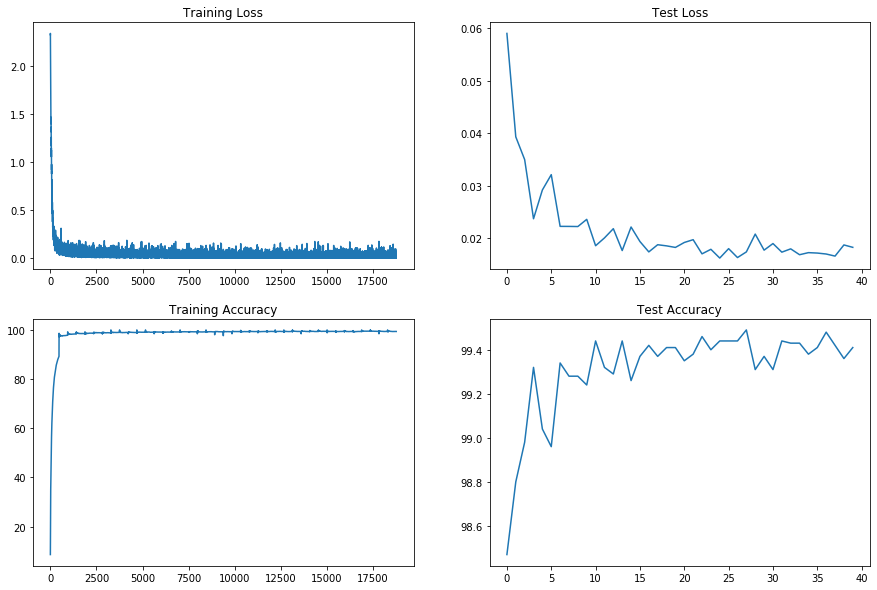

In [14]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

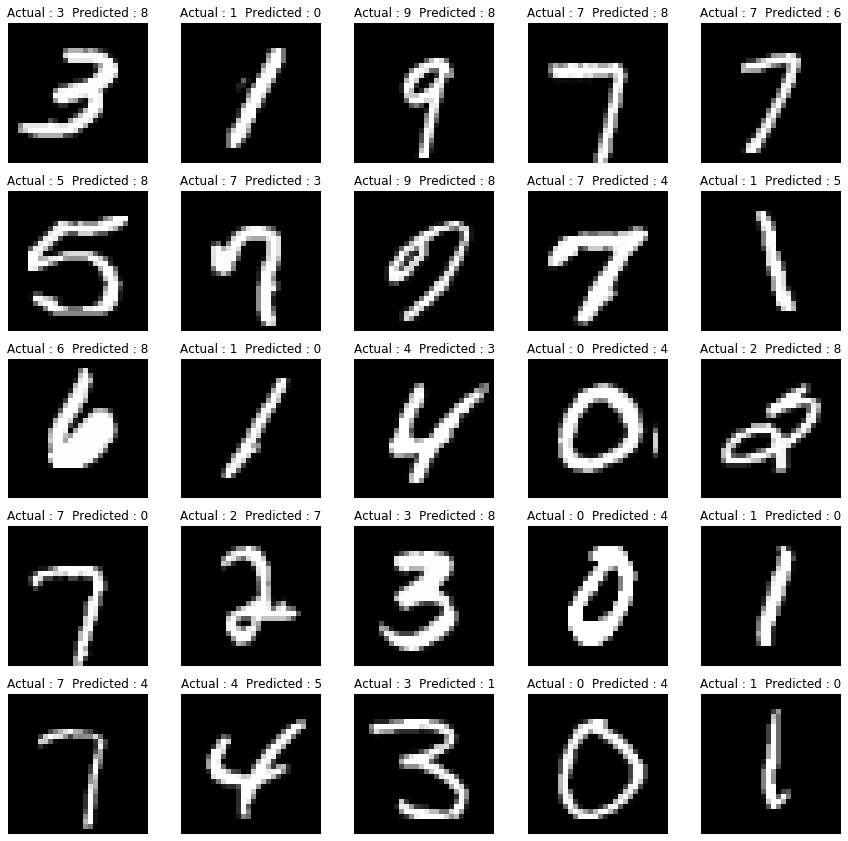

In [15]:
img, targ, pred = find_misclassified(model)
plot_misclassified(img, targ, pred)

##Using only L2 Regularization

In [12]:
run_model(epochs=40, l2=0.000005)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 1


Loss=0.1361473798751831 Batch_id=468 Accuracy=89.32: 100%|██████████| 469/469 [00:16<00:00, 28.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0645, Accuracy: 9822/10000 (98.22%)

EPOCH: 2


Loss=0.029079586267471313 Batch_id=468 Accuracy=97.81: 100%|██████████| 469/469 [00:16<00:00, 28.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0413, Accuracy: 9876/10000 (98.76%)

EPOCH: 3


Loss=0.033289726823568344 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:16<00:00, 28.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0334, Accuracy: 9887/10000 (98.87%)

EPOCH: 4


Loss=0.08243416249752045 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:16<00:00, 28.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9923/10000 (99.23%)

EPOCH: 5


Loss=0.015538404695689678 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:16<00:00, 29.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0341, Accuracy: 9900/10000 (99.00%)

EPOCH: 6


Loss=0.045244455337524414 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:16<00:00, 33.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9919/10000 (99.19%)

EPOCH: 7


Loss=0.07717356830835342 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:16<00:00, 27.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9924/10000 (99.24%)

EPOCH: 8


Loss=0.024913974106311798 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:16<00:00, 33.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0244, Accuracy: 9921/10000 (99.21%)

EPOCH: 9


Loss=0.13107341527938843 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:17<00:00, 27.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9925/10000 (99.25%)

EPOCH: 10


Loss=0.02594682388007641 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:16<00:00, 27.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9922/10000 (99.22%)

EPOCH: 11


Loss=0.0528017021715641 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:16<00:00, 28.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9931/10000 (99.31%)

EPOCH: 12


Loss=0.02750883251428604 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:16<00:00, 27.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9941/10000 (99.41%)

EPOCH: 13


Loss=0.009392167441546917 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:16<00:00, 27.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9930/10000 (99.30%)

EPOCH: 14


Loss=0.006845881696790457 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:16<00:00, 28.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 9946/10000 (99.46%)

EPOCH: 15


Loss=0.01374844741076231 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:16<00:00, 28.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9928/10000 (99.28%)

EPOCH: 16


Loss=0.029769791290163994 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:17<00:00, 27.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9943/10000 (99.43%)

EPOCH: 17


Loss=0.005403786897659302 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:16<00:00, 28.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9936/10000 (99.36%)

EPOCH: 18


Loss=0.03513963147997856 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:16<00:00, 28.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9936/10000 (99.36%)

EPOCH: 19


Loss=0.03694907948374748 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:17<00:00, 27.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9939/10000 (99.39%)

EPOCH: 20


Loss=0.012273584492504597 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:16<00:00, 28.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9940/10000 (99.40%)

EPOCH: 21


Loss=0.14798276126384735 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:16<00:00, 29.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 9942/10000 (99.42%)

EPOCH: 22


Loss=0.0030664801597595215 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:16<00:00, 28.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 9945/10000 (99.45%)

EPOCH: 23


Loss=0.01438188087195158 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:16<00:00, 28.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9945/10000 (99.45%)

EPOCH: 24


Loss=0.005549097899347544 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:16<00:00, 28.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9935/10000 (99.35%)

EPOCH: 25


Loss=0.017715096473693848 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:16<00:00, 28.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9941/10000 (99.41%)

EPOCH: 26


Loss=0.006063754204660654 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:16<00:00, 28.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Accuracy: 9949/10000 (99.49%)

EPOCH: 27


Loss=0.04279144108295441 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:15<00:00, 29.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9943/10000 (99.43%)

EPOCH: 28


Loss=0.012419159524142742 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:16<00:00, 29.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9938/10000 (99.38%)

EPOCH: 29


Loss=0.004731898661702871 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:18<00:00, 25.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 9941/10000 (99.41%)

EPOCH: 30


Loss=0.030582299456000328 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:16<00:00, 27.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9934/10000 (99.34%)

EPOCH: 31


Loss=0.002721523167565465 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:16<00:00, 28.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Accuracy: 9939/10000 (99.39%)

EPOCH: 32


Loss=0.019781848415732384 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:17<00:00, 26.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0163, Accuracy: 9949/10000 (99.49%)

EPOCH: 33


Loss=0.00934216845780611 Batch_id=468 Accuracy=99.43: 100%|██████████| 469/469 [00:17<00:00, 27.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0159, Accuracy: 9946/10000 (99.46%)

EPOCH: 34


Loss=0.04694013670086861 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:17<00:00, 27.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0150, Accuracy: 9947/10000 (99.47%)

EPOCH: 35


Loss=0.022081518545746803 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:17<00:00, 26.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0165, Accuracy: 9943/10000 (99.43%)

EPOCH: 36


Loss=0.002069920301437378 Batch_id=468 Accuracy=99.43: 100%|██████████| 469/469 [00:17<00:00, 27.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0167, Accuracy: 9946/10000 (99.46%)

EPOCH: 37


Loss=0.003398209810256958 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:17<00:00, 27.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9946/10000 (99.46%)

EPOCH: 38


Loss=0.14968322217464447 Batch_id=468 Accuracy=99.46: 100%|██████████| 469/469 [00:17<00:00, 26.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0171, Accuracy: 9938/10000 (99.38%)

EPOCH: 39


Loss=0.03854023292660713 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:17<00:00, 27.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0151, Accuracy: 9951/10000 (99.51%)

EPOCH: 40


Loss=0.016387054696679115 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:16<00:00, 27.83it/s]



Test set: Average loss: 0.0143, Accuracy: 9950/10000 (99.50%)



In [0]:
temp=metrics()
with open('mylist_l2', 'wb') as f:
  pickle.dump(temp, f)

Text(0.5, 1.0, 'Test Accuracy')

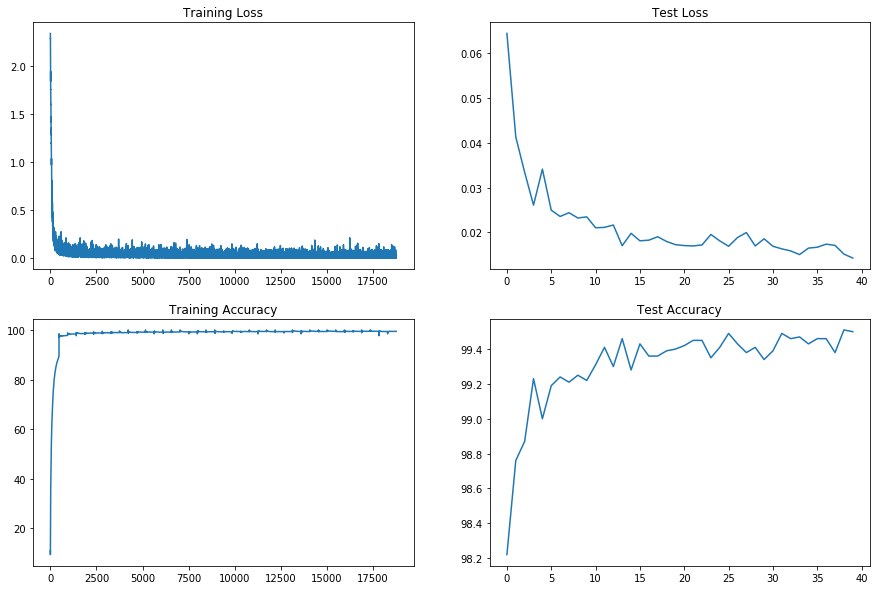

In [14]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

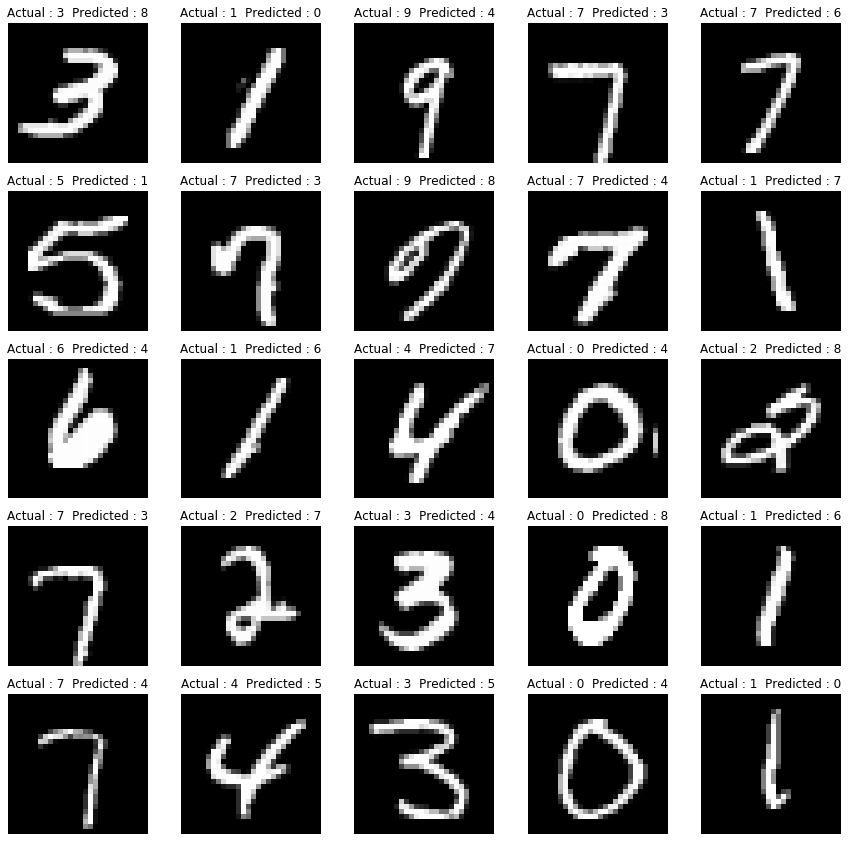

In [15]:
img, targ, pred = find_misclassified(model)
plot_misclassified(img, targ, pred)

## Using only L1 Regularization

In [21]:
run_model(epochs=40, l1=0.000001)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 1


Loss=0.10610262304544449 Batch_id=468 Accuracy=88.92: 100%|██████████| 469/469 [00:16<00:00, 27.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0701, Accuracy: 9816/10000 (98.16%)

EPOCH: 2


Loss=0.0661270022392273 Batch_id=468 Accuracy=97.91: 100%|██████████| 469/469 [00:16<00:00, 28.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0429, Accuracy: 9882/10000 (98.82%)

EPOCH: 3


Loss=0.1055317372083664 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:16<00:00, 28.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0294, Accuracy: 9915/10000 (99.15%)

EPOCH: 4


Loss=0.08697092533111572 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:16<00:00, 27.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9910/10000 (99.10%)

EPOCH: 5


Loss=0.023526739329099655 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:16<00:00, 28.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0301, Accuracy: 9899/10000 (98.99%)

EPOCH: 6


Loss=0.08842388540506363 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:16<00:00, 28.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9921/10000 (99.21%)

EPOCH: 7


Loss=0.0517759844660759 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:16<00:00, 33.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9936/10000 (99.36%)

EPOCH: 8


Loss=0.020431142300367355 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:16<00:00, 28.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9930/10000 (99.30%)

EPOCH: 9


Loss=0.07590867578983307 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:16<00:00, 28.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9933/10000 (99.33%)

EPOCH: 10


Loss=0.05316906422376633 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:16<00:00, 29.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9933/10000 (99.33%)

EPOCH: 11


Loss=0.008653250522911549 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:17<00:00, 27.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9935/10000 (99.35%)

EPOCH: 12


Loss=0.04072727635502815 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:17<00:00, 27.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9924/10000 (99.24%)

EPOCH: 13


Loss=0.022997654974460602 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:17<00:00, 27.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9937/10000 (99.37%)

EPOCH: 14


Loss=0.040446944534778595 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:17<00:00, 26.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9942/10000 (99.42%)

EPOCH: 15


Loss=0.04902972653508186 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:17<00:00, 27.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9936/10000 (99.36%)

EPOCH: 16


Loss=0.009001712314784527 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:17<00:00, 27.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9943/10000 (99.43%)

EPOCH: 17


Loss=0.009735580533742905 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:17<00:00, 34.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9934/10000 (99.34%)

EPOCH: 18


Loss=0.07457823306322098 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:17<00:00, 27.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9937/10000 (99.37%)

EPOCH: 19


Loss=0.024863528087735176 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:18<00:00, 26.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9939/10000 (99.39%)

EPOCH: 20


Loss=0.038566701114177704 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:18<00:00, 25.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9937/10000 (99.37%)

EPOCH: 21


Loss=0.030420377850532532 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:17<00:00, 26.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9941/10000 (99.41%)

EPOCH: 22


Loss=0.06471261382102966 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:17<00:00, 26.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9940/10000 (99.40%)

EPOCH: 23


Loss=0.004618909675627947 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:17<00:00, 26.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0167, Accuracy: 9938/10000 (99.38%)

EPOCH: 24


Loss=0.00294101401232183 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:17<00:00, 26.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0166, Accuracy: 9944/10000 (99.44%)

EPOCH: 25


Loss=0.02183869108557701 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:17<00:00, 26.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0148, Accuracy: 9949/10000 (99.49%)

EPOCH: 26


Loss=0.008362740278244019 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:17<00:00, 26.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Accuracy: 9945/10000 (99.45%)

EPOCH: 27


Loss=0.06578972935676575 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:17<00:00, 27.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9941/10000 (99.41%)

EPOCH: 28


Loss=0.006107712164521217 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:17<00:00, 26.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0150, Accuracy: 9944/10000 (99.44%)

EPOCH: 29


Loss=0.029185311868786812 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:17<00:00, 26.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0164, Accuracy: 9939/10000 (99.39%)

EPOCH: 30


Loss=0.006105748936533928 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:17<00:00, 26.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0166, Accuracy: 9943/10000 (99.43%)

EPOCH: 31


Loss=0.012390466406941414 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:17<00:00, 26.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0163, Accuracy: 9947/10000 (99.47%)

EPOCH: 32


Loss=0.023066744208335876 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:17<00:00, 27.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9946/10000 (99.46%)

EPOCH: 33


Loss=0.0024869833141565323 Batch_id=468 Accuracy=99.46: 100%|██████████| 469/469 [00:17<00:00, 27.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0151, Accuracy: 9952/10000 (99.52%)

EPOCH: 34


Loss=0.0062378630973398685 Batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:16<00:00, 27.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 9948/10000 (99.48%)

EPOCH: 35


Loss=0.006761082913726568 Batch_id=468 Accuracy=99.40: 100%|██████████| 469/469 [00:16<00:00, 27.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9941/10000 (99.41%)

EPOCH: 36


Loss=0.035298023372888565 Batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:17<00:00, 26.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0164, Accuracy: 9939/10000 (99.39%)

EPOCH: 37


Loss=0.014971514232456684 Batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:17<00:00, 27.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0162, Accuracy: 9951/10000 (99.51%)

EPOCH: 38


Loss=0.0030287597328424454 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:17<00:00, 26.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9944/10000 (99.44%)

EPOCH: 39


Loss=0.010838926769793034 Batch_id=468 Accuracy=99.45: 100%|██████████| 469/469 [00:17<00:00, 27.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0162, Accuracy: 9946/10000 (99.46%)

EPOCH: 40


Loss=0.004720740485936403 Batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:16<00:00, 27.86it/s]



Test set: Average loss: 0.0171, Accuracy: 9947/10000 (99.47%)



In [0]:
temp=metrics()
with open('mylist_l1', 'wb') as f:
  pickle.dump(temp, f)

Text(0.5, 1.0, 'Test Accuracy')

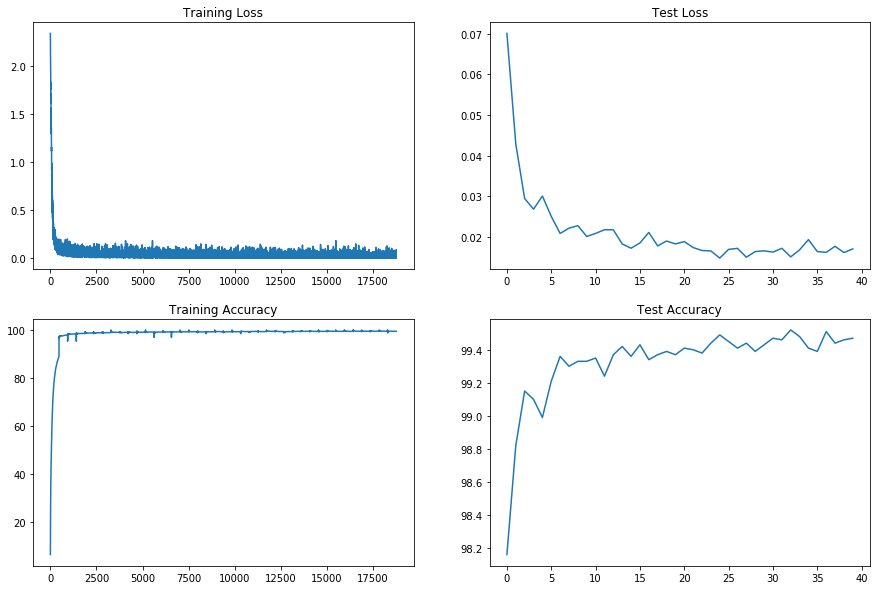

In [23]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

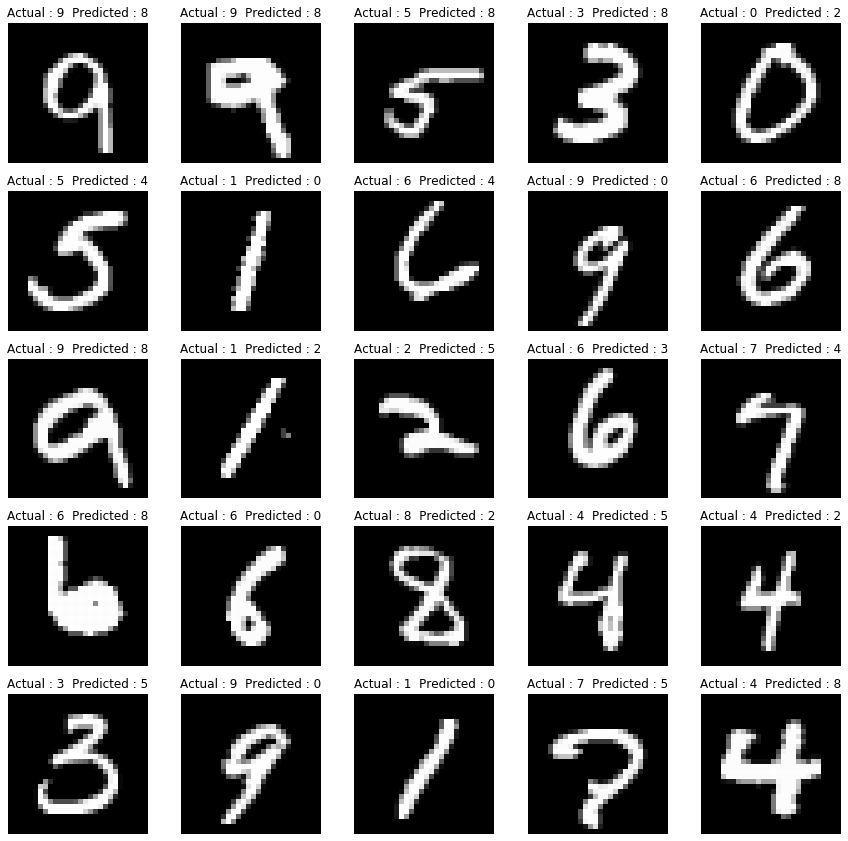

In [24]:
img, targ, pred = find_misclassified(model)
plot_misclassified(img, targ, pred)

##Using both L1 and L2 Regressions

In [12]:
run_model(epochs=40, l1=0.000001, l2=0.000001)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 1


Loss=0.13459379971027374 Batch_id=468 Accuracy=89.33: 100%|██████████| 469/469 [00:15<00:00, 30.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0647, Accuracy: 9822/10000 (98.22%)

EPOCH: 2


Loss=0.03450683504343033 Batch_id=468 Accuracy=97.81: 100%|██████████| 469/469 [00:14<00:00, 31.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0398, Accuracy: 9883/10000 (98.83%)

EPOCH: 3


Loss=0.03352116048336029 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:15<00:00, 31.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0352, Accuracy: 9881/10000 (98.81%)

EPOCH: 4


Loss=0.09992381185293198 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:15<00:00, 29.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Accuracy: 9923/10000 (99.23%)

EPOCH: 5


Loss=0.013706440106034279 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:15<00:00, 30.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0371, Accuracy: 9890/10000 (98.90%)

EPOCH: 6


Loss=0.04560917988419533 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:15<00:00, 30.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0260, Accuracy: 9915/10000 (99.15%)

EPOCH: 7


Loss=0.0750197321176529 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:15<00:00, 30.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0244, Accuracy: 9917/10000 (99.17%)

EPOCH: 8


Loss=0.027758978307247162 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:15<00:00, 30.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Accuracy: 9923/10000 (99.23%)

EPOCH: 9


Loss=0.1095295250415802 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:15<00:00, 30.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9924/10000 (99.24%)

EPOCH: 10


Loss=0.03714931756258011 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:15<00:00, 30.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9925/10000 (99.25%)

EPOCH: 11


Loss=0.04426737129688263 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:16<00:00, 28.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9938/10000 (99.38%)

EPOCH: 12


Loss=0.023108365014195442 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:15<00:00, 30.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9928/10000 (99.28%)

EPOCH: 13


Loss=0.00593478512018919 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:15<00:00, 30.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9933/10000 (99.33%)

EPOCH: 14


Loss=0.01533261314034462 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:15<00:00, 29.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9942/10000 (99.42%)

EPOCH: 15


Loss=0.02559351921081543 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:15<00:00, 29.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9930/10000 (99.30%)

EPOCH: 16


Loss=0.031840670853853226 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:15<00:00, 29.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9939/10000 (99.39%)

EPOCH: 17


Loss=0.005426540970802307 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:15<00:00, 30.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9938/10000 (99.38%)

EPOCH: 18


Loss=0.009083743207156658 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:16<00:00, 28.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9939/10000 (99.39%)

EPOCH: 19


Loss=0.052294664084911346 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:15<00:00, 29.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9942/10000 (99.42%)

EPOCH: 20


Loss=0.005281616002321243 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:15<00:00, 29.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9941/10000 (99.41%)

EPOCH: 21


Loss=0.11425775289535522 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:16<00:00, 29.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0154, Accuracy: 9947/10000 (99.47%)

EPOCH: 22


Loss=0.003645728575065732 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:15<00:00, 35.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9946/10000 (99.46%)

EPOCH: 23


Loss=0.01931067556142807 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:15<00:00, 29.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0167, Accuracy: 9948/10000 (99.48%)

EPOCH: 24


Loss=0.006191547494381666 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:15<00:00, 29.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 9947/10000 (99.47%)

EPOCH: 25


Loss=0.005017487797886133 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:16<00:00, 28.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9942/10000 (99.42%)

EPOCH: 26


Loss=0.008911335840821266 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:15<00:00, 29.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0166, Accuracy: 9949/10000 (99.49%)

EPOCH: 27


Loss=0.04369393736124039 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:16<00:00, 29.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9940/10000 (99.40%)

EPOCH: 28


Loss=0.0054080854170024395 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:16<00:00, 28.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9944/10000 (99.44%)

EPOCH: 29


Loss=0.0107291704043746 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:16<00:00, 29.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0166, Accuracy: 9943/10000 (99.43%)

EPOCH: 30


Loss=0.04344477877020836 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:16<00:00, 29.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9946/10000 (99.46%)

EPOCH: 31


Loss=0.003916285000741482 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:16<00:00, 29.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0149, Accuracy: 9953/10000 (99.53%)

EPOCH: 32


Loss=0.02358521893620491 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:16<00:00, 28.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0154, Accuracy: 9952/10000 (99.52%)

EPOCH: 33


Loss=0.01717560552060604 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:16<00:00, 29.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0152, Accuracy: 9951/10000 (99.51%)

EPOCH: 34


Loss=0.03724177926778793 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:15<00:00, 29.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0156, Accuracy: 9951/10000 (99.51%)

EPOCH: 35


Loss=0.03376137092709541 Batch_id=468 Accuracy=99.40: 100%|██████████| 469/469 [00:16<00:00, 28.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 9948/10000 (99.48%)

EPOCH: 36


Loss=0.008833032101392746 Batch_id=468 Accuracy=99.40: 100%|██████████| 469/469 [00:15<00:00, 29.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0154, Accuracy: 9948/10000 (99.48%)

EPOCH: 37


Loss=0.00942382775247097 Batch_id=468 Accuracy=99.48: 100%|██████████| 469/469 [00:15<00:00, 29.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0165, Accuracy: 9952/10000 (99.52%)

EPOCH: 38


Loss=0.14131146669387817 Batch_id=468 Accuracy=99.48: 100%|██████████| 469/469 [00:16<00:00, 28.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0171, Accuracy: 9939/10000 (99.39%)

EPOCH: 39


Loss=0.013629807159304619 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:15<00:00, 29.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0155, Accuracy: 9953/10000 (99.53%)

EPOCH: 40


Loss=0.017729323357343674 Batch_id=468 Accuracy=99.45: 100%|██████████| 469/469 [00:16<00:00, 29.30it/s]



Test set: Average loss: 0.0156, Accuracy: 9946/10000 (99.46%)



In [0]:
temp=metrics()
with open('mylist_l1_l2', 'wb') as f:
  pickle.dump(temp, f)

Text(0.5, 1.0, 'Test Accuracy')

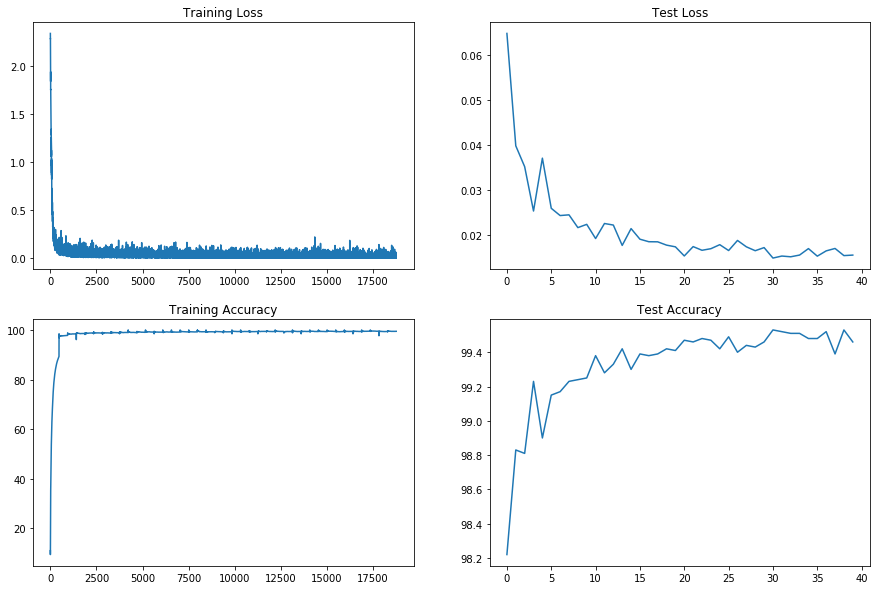

In [14]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

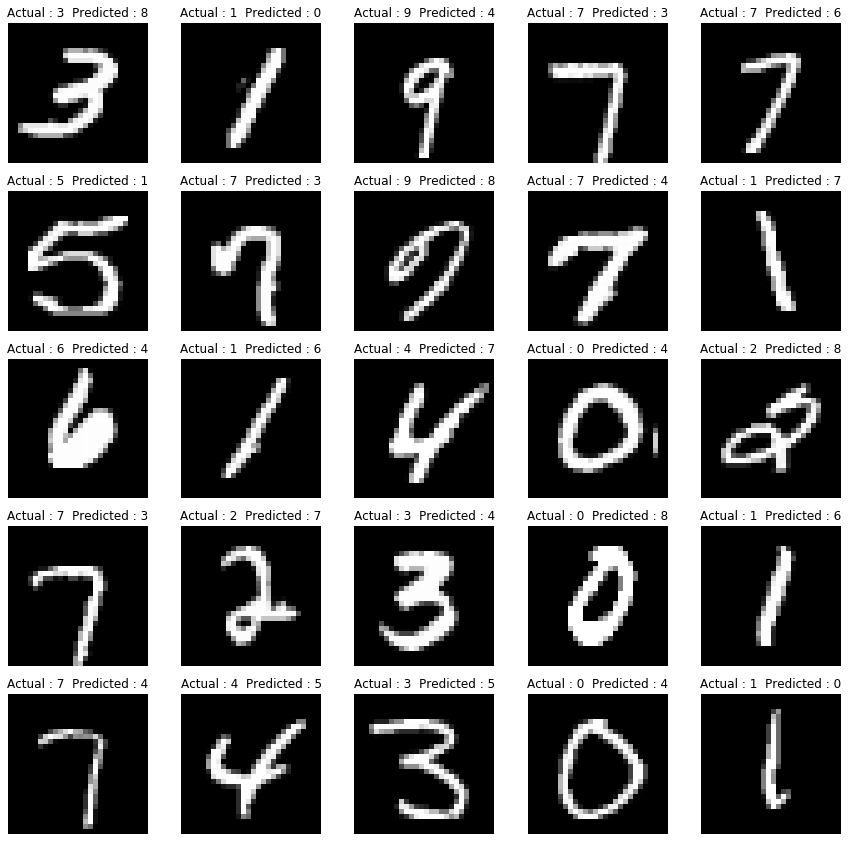

In [15]:
img, targ, pred = find_misclassified(model)
plot_misclassified(img, targ, pred)

##Loading and plotting the values

In [0]:
with open('mylist', 'rb') as f:
  no_reg = pickle.load(f)
with open('mylist_l1', 'rb') as f:
  l1_reg = pickle.load(f)
with open('mylist_l2', 'rb') as f:
  l2_reg = pickle.load(f)
with open('mylist_l1_l2', 'rb') as f:
  l1l2_reg = pickle.load(f)

###Validation accuracy

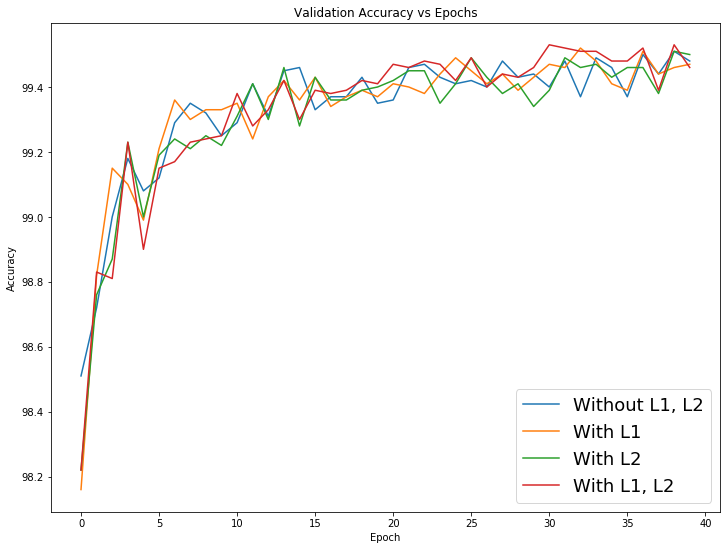

In [45]:

fig, axs = plt.subplots(1,1,figsize=(12,9))
axs.plot(no_reg[3], label='Without L1, L2')
axs.plot(l1_reg[3], label='With L1')
axs.plot(l2_reg[3], label='With L2')
axs.plot(l1l2_reg[3], label='With L1, L2')
axs.set_title("Validation Accuracy vs Epochs")
axs.set_xlabel("Epoch")
axs.set_ylabel("Accuracy")
axs.legend(loc='lower right', prop={'size': 18})


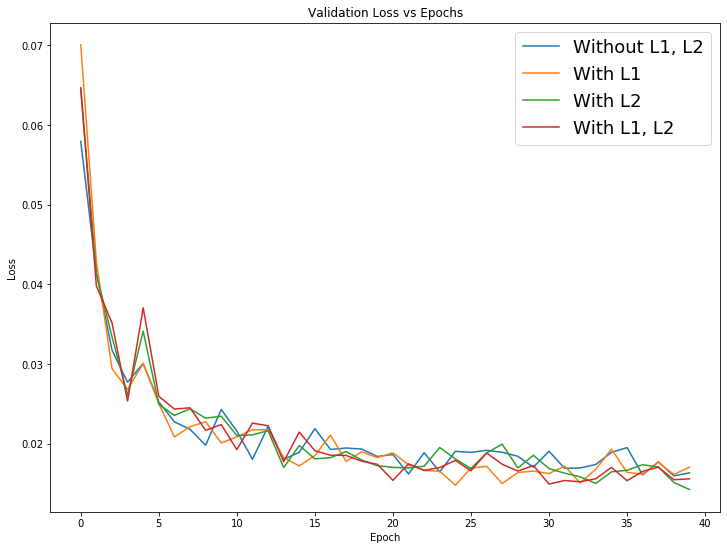

In [46]:
fig, axs = plt.subplots(1,1,figsize=(12,9))
axs.plot(no_reg[1], label='Without L1, L2')
axs.plot(l1_reg[1], label='With L1')
axs.plot(l2_reg[1], label='With L2')
axs.plot(l1l2_reg[1], label='With L1, L2')
axs.set_title("Validation Loss vs Epochs")
axs.set_xlabel("Epoch")
axs.set_ylabel("Loss")
axs.legend(loc='upper right', prop={'size': 18})
